In [ ]:
!pip install catboost scikit-plot

# Original Notebook

In [1]:
import pandas as pd
import numpy as np

import re, math, os



from collections import Counter, defaultdict

from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import catboost as ctb
#import lightgbm as lgb

from sklearn.metrics import accuracy_score, f1_score
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

p = lambda x: print(x)

%matplotlib inline

### Download IMDB from IBM Cloud Object Storage

As we did previously e.g. in Lab.I.80, let's collect individual training reviews into a list of chains: one chain per review.
We also collect review labels (positive/negative) for the labels list.

In [ ]:
import os, types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

""" if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_a205bd0ef67d4e43a20f54571521aa41 = 'https://s3-api.us-geo.objectstorage.softlayer.net'
else:
    endpoint_a205bd0ef67d4e43a20f54571521aa41 = 'https://s3-api.us-geo.objectstorage.service.networklayer.com' """

endpoint_a205bd0ef67d4e43a20f54571521aa41 = 'https://s3-api.us-geo.objectstorage.softlayer.net'

client_a205bd0ef67d4e43a20f54571521aa41 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='3oTQ_GU9OAHXSgCgxR06S1CTzFOR44-4KvNuuoVgBqux',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_a205bd0ef67d4e43a20f54571521aa41)
# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_4 = client_a205bd0ef67d4e43a20f54571521aa41.get_object(Bucket='2020l-donotdelete-pr-iya5gjhbhguf6w', Key='aclImdb.zip')['Body']
# add missing __iter__ method so pandas accepts body as file-like object
if not hasattr(streaming_body_4, "__iter__"): streaming_body_4.__iter__ = types.MethodType( __iter__, streaming_body_4 ) 
    
data = streaming_body_4._raw_stream  
with open("imdb.zip", "wb") as outfile:
    # Copy the BytesIO stream to the output file
    outfile.write(data.read())
    
import zipfile
with zipfile.ZipFile('imdb.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

We take the 'train' dataset from the files

In [ ]:
imdb_dir = './aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
# create and load df from lists 'labels' and 'texts'
df = pd.DataFrame(columns=['labels', 'texts'])
df['labels']=labels
df['texts']=texts

df.to_csv('df.csv', index=False)

In [2]:
df = pd.read_csv('df.csv')
df

,labels,texts
0,0,Story of a man who has unnatural feelings for ...
1,0,Airport '77 starts as a brand new luxury 747 p...
2,0,This film lacked something I couldn't put my f...
3,0,"Sorry everyone,,, I know this is supposed to b..."
4,0,When I was little my parents took me along to ...
...,...,...
24995,1,"Seeing as the vote average was pretty low, and..."
24996,1,"The plot had some wretched, unbelievable twist..."
24997,1,I am amazed at how this movie(and most others ...
24998,1,A Christmas Together actually came before my t...


In [3]:
# mixing
df = df.sample(frac = 1.0, random_state=33)

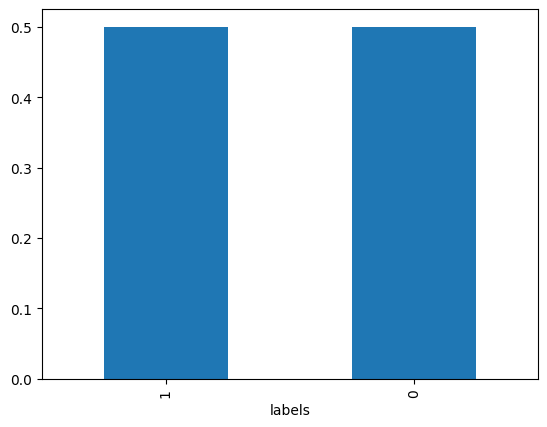

In [4]:
# distribution of labels in the training set
df['labels'].value_counts(normalize=True).plot(kind='bar');

In [5]:
# light normalization
df['texts_norm'] = df['texts'].str.lower()
df

,labels,texts,texts_norm
17797,1,"Drum scene is wild! Cook, Jr. is unsung hero o...","drum scene is wild! cook, jr. is unsung hero o..."
6458,0,"This movie is possibly the cheapest, cheesiest...","this movie is possibly the cheapest, cheesiest..."
14478,1,The documentary presents an original theory ab...,the documentary presents an original theory ab...
14825,1,Italy produced a lot of really great and origi...,italy produced a lot of really great and origi...
7523,0,I just came from seeing this movie and decided...,i just came from seeing this movie and decided...
...,...,...,...
57,0,I gave this 4 stars because it has a lot of in...,i gave this 4 stars because it has a lot of in...
578,0,Angels who got a little icky were banned from ...,angels who got a little icky were banned from ...
5848,0,After watching some of HBO's great stuff - Ban...,after watching some of hbo's great stuff - ban...
2439,0,The actors did a really good job playing their...,the actors did a really good job playing their...


In [6]:
test_initial_1 = df.iloc[0]['texts_norm']
test_initial_1

'drum scene is wild! cook, jr. is unsung hero of this and many movies. fantastic actor, great flick. a few twists that keep you moving. a must-see.'

In [7]:
# tokenization
tokens_set = set()
df['texts_norm'].str.split(" ").map(tokens_set.update)

len(tokens_set)

252192

In [8]:
# what are the most frequent tokens? -> Counter(tokens_set).most_common()
cntr = Counter()
df["texts_norm"].str.split(" ").map(cntr.update)
cntr.most_common(n=5)

[('the', 322174),
 ('a', 159949),
 ('and', 158556),
 ('of', 144459),
 ('to', 133965)]

In [9]:
def get_df_topn(text: pd.Series, topn: int, counter_tokens: Counter):

    top_tokens = [x[0] for x in counter_tokens.most_common(n=topn)]

    def check_top_n(sent_tokens):
        return [int(token in sent_tokens) for token in top_tokens]

    df_topn = text.str.split(" ").map(set).map(check_top_n).apply(pd.Series) # .apply: If func returns a Series object the result will be a DataFrame.
    df_topn.columns = top_tokens

    return df_topn

In [10]:
df_top50 = get_df_topn(df["texts_norm"], topn=50, counter_tokens=cntr)

df_top50

,the,a,and,of,to,is,in,i,this,that,...,her,about,it's,some,if,out,what,very,when,more
17797,0,1,1,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
6458,1,1,1,1,1,1,1,1,1,1,...,0,1,0,0,0,0,1,1,1,1
14478,1,1,1,1,1,1,1,1,1,0,...,0,1,0,0,1,0,0,0,0,0
14825,1,1,1,1,1,1,1,0,1,1,...,1,1,1,0,0,0,0,1,1,1
7523,1,1,1,1,1,1,0,1,1,1,...,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,1,1,1,1,1,0,1,1,1,1,...,0,0,1,0,1,0,0,1,0,0
578,1,1,1,1,1,1,1,0,1,1,...,0,1,0,0,0,0,0,0,0,0
5848,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1
2439,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,1,0,1,0,1


In [11]:
# For how many opinions the category cannot be determined based on the selected number of tokens? 
result = []
for topn in [1, 5, 10, 20, 50, 100]:
    df_topn = get_df_topn( df['texts_norm'], topn=topn, counter_tokens=cntr)
    missing = df_topn[ df_topn.sum(axis=1) == 0 ].shape
    
    result.append((topn, missing))
    print('n={}, missing={}'.format(topn, missing))

n=1, missing=(229, 1)
n=5, missing=(8, 5)
n=10, missing=(4, 10)
n=20, missing=(2, 20)
n=50, missing=(0, 50)
n=100, missing=(0, 100)


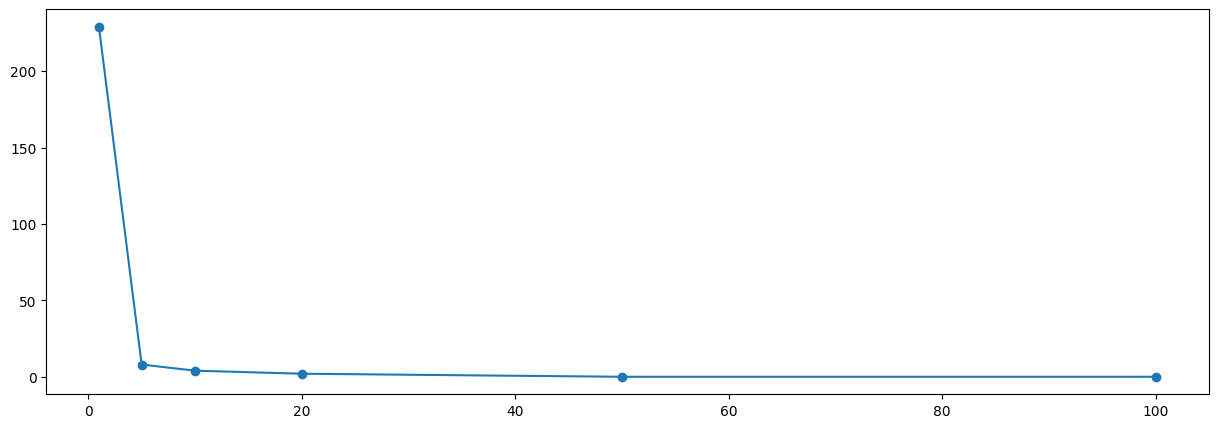

In [12]:
x = [i[0] for i in result]
y = [i[1][0] for i in result]

plt.figure(figsize=(15, 5))
plt.plot( x, y, 'o-' );

## <span style="color:yellow">Introduction to modelling: *bag of words*</span>

### <span style="color:yellow">Approach based on manual tokenization</span>

<span style="color:#ffff00">Check on the test data</span>

In [ ]:
imdb_dir = './aclImdb'
test_dir = os.path.join(imdb_dir, 'test')

labels_test = []
texts_test = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts_test.append(f.read())
            f.close()
            if label_type == 'neg':
                labels_test.append(0)
            else:
                labels_test.append(1)

df_test = pd.DataFrame(columns=['labels', 'texts'])
df_test['labels']=labels_test
df_test['texts']=texts_test
df_test.to_csv('df_test.csv', index=False)

In [13]:
df_test = pd.read_csv('df_test.csv')
df_test

,labels,texts
0,0,Once again Mr. Costner has dragged out a movie...
1,0,This is an example of why the majority of acti...
2,0,"First of all I hate those moronic rappers, who..."
3,0,Not even the Beatles could write songs everyon...
4,0,Brass pictures (movies is not a fitting word f...
...,...,...
24995,1,I was extraordinarily impressed by this film. ...
24996,1,"Although I'm not a golf fan, I attended a snea..."
24997,1,"From the start of ""The Edge Of Love"", the view..."
24998,1,"This movie, with all its complexity and subtle..."


In [14]:
df_test = df_test.sample(frac = 1.0, random_state=33)
df_test['texts_norm'] = df_test['texts'].str.lower()

In [15]:
df_test.iloc[:25000]

,labels,texts,texts_norm
17797,1,for a movie like this little hidden gem to com...,for a movie like this little hidden gem to com...
6458,0,This is an old-dark-house movie. A young coupl...,this is an old-dark-house movie. a young coupl...
14478,1,The hysterical Hardware Wars is finally out on...,the hysterical hardware wars is finally out on...
14825,1,"Turkish-German director Faith Akın (""Head-On"" ...","turkish-german director faith akın (""head-on"" ..."
7523,0,HAPPY DAYS was one of my favorite shows when i...,happy days was one of my favorite shows when i...
...,...,...,...
57,0,I had to see this on the British Airways plane...,i had to see this on the british airways plane...
578,0,"A blatant rip-off of ""Air Bud"", this movie is ...","a blatant rip-off of ""air bud"", this movie is ..."
5848,0,This video has audio that is meant for someone...,this video has audio that is meant for someone...
2439,0,I watched this movie with no idea what it was ...,i watched this movie with no idea what it was ...


In [16]:
#let's take an example
df_test.iloc[4]['texts_norm']

'happy days was one of my favorite shows when it aired in 1974. but the critics were quick to show their ignorance combined with a total lack of a sense of humor by slamming this show because they thought it was a cheap attempt to cash-in on the success of american graffitti.<br /><br />there were some similarities between american graffitti and happy days.<br /><br />both opened with "rock around the clock" by bill haley & the comets. both took place in a bygone era and both featured ron howard as one of the leading roles. but there were also some major differences. while american graffitti took place in 1962 california and centered around a group of newly graduated high school students about to take that big step into adulthood, happy days took place in milwaulkee, wisconson and centered around a group of teenagers in high school, dealing with the joys and tribulations of adolescence.<br /><br />happy days originally opened with the juke box playing the original version of bill haley

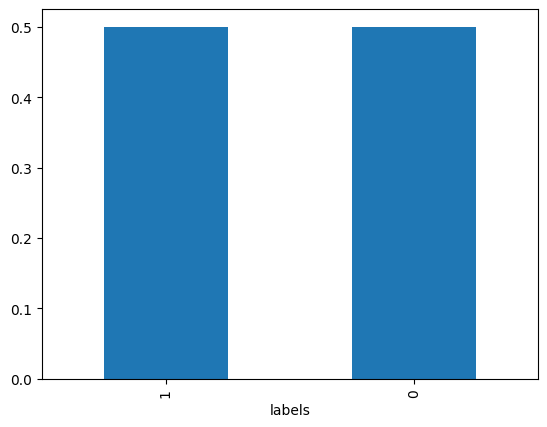

In [17]:
df_test.iloc[:25000]['labels'].value_counts(normalize=True).plot(kind='bar');

In [18]:
y = df_test.iloc[:25000]['labels']
y1 = df_test.iloc[:25000]['labels'].values.tolist()

### NOTE!!! df and df_test both had the same sample seed = 33, so the same samples are in the same order in both dataframes

In [19]:
import pandas as pd
# We choose a priori 50 as the number of dimensions we will use for classification
# X = get_df_topn( df['texts_norm'], 50, counter_tokens=cntr).values

max_features = 50

X = get_df_topn( df['texts_norm'], max_features, counter_tokens=cntr)
# Replace the special characters in the column names
new_columns = [col.replace('[', '').replace(']', '').replace('<', '') for col in X.columns]

# Rename the columns in the DataFrame
X.rename(columns=dict(zip(X.columns, new_columns)), inplace=True)



#y = (df['target'] == 'spam').astype(np.int8).values
#y = df['labels'].factorize()[0]

In [21]:
def get_models2(use_dummy):
    
    models = [('dummy', DummyClassifier(strategy='stratified'))] if use_dummy else []
    
    models += [
        ('catboost', ctb.CatBoostClassifier(n_estimators=50, max_depth=5, random_state=0, verbose=0)),
        ('xgboost', xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=0)),
        ('LogisticRegression', LogisticRegression(random_state=0))
    ] 
    return models

In [22]:
def run_models2(X, y, use_dummy=True, scoring='accuracy', plot_result=False, show_confusion_matrix=True):
    result = []
    #cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    
    num_cols = 4
    if show_confusion_matrix:
        fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(15,10))


    for it, (model_name, model) in enumerate(get_models2(use_dummy)):
        clf = model
        clf.fit(X,y)
        y_pred = clf.predict(X)
        score = accuracy_score(y, y_pred)
        print("model={}, accuracy={}".format(model_name, score))

        if show_confusion_matrix:
            ax = axes[it]
            disp = ConfusionMatrixDisplay.from_predictions(y,y_pred,ax=ax,colorbar=None)
            disp.ax_.set_title('model: {}'.format(model_name))

model=dummy, accuracy=0.49996
model=catboost, accuracy=0.66564
model=xgboost, accuracy=0.69864
model=LogisticRegression, accuracy=0.61912


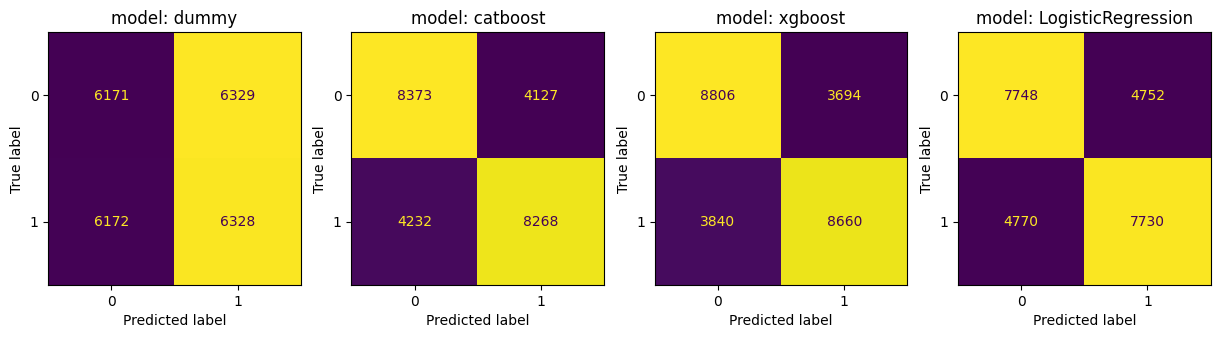

In [23]:
run_models2(X,y1)

In [24]:
# Let's take a classifier giving the best results
xgboost_clf = xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=0)
xgboost_clf.fit(X,y1)

y_pred = xgboost_clf.predict(X)
accuracy_score(y1, y_pred)

0.69864

In [25]:
len(y_pred)

25000

In [26]:
def predicta(text):
    # del dft
    # text = purify(text)
    dft = pd.DataFrame({'texts':[text]})
    dft['texts_norm'] = dft['texts'].str.lower()
    return xgboost_clf.predict(get_df_topn(dft["texts_norm"], max_features, counter_tokens=cntr).values)[0]
    # return dft

In [27]:
cat=["negative", "positive"]

In [28]:
cat[predicta(df_test.iloc[0]['texts_norm'])]

'positive'

### <span style="color:yellow">Scikit-learn built-in tokenization</span>

In [29]:
vectorizer = CountVectorizer(binary=True, max_features=max_features)
XV = vectorizer.fit_transform(df['texts'])
vectorizer.get_feature_names_out()

array(['about', 'all', 'an', 'and', 'are', 'as', 'at', 'be', 'br', 'but',
       'by', 'can', 'film', 'for', 'from', 'good', 'has', 'have', 'he',
       'his', 'if', 'in', 'is', 'it', 'just', 'like', 'more', 'movie',
       'not', 'of', 'on', 'one', 'or', 'out', 'so', 'some', 'that', 'the',
       'there', 'they', 'this', 'time', 'to', 'up', 'was', 'what', 'when',
       'who', 'with', 'you'], dtype=object)

model=dummy, accuracy=0.49452
model=catboost, accuracy=0.66112
model=xgboost, accuracy=0.69272
model=LogisticRegression, accuracy=0.61572


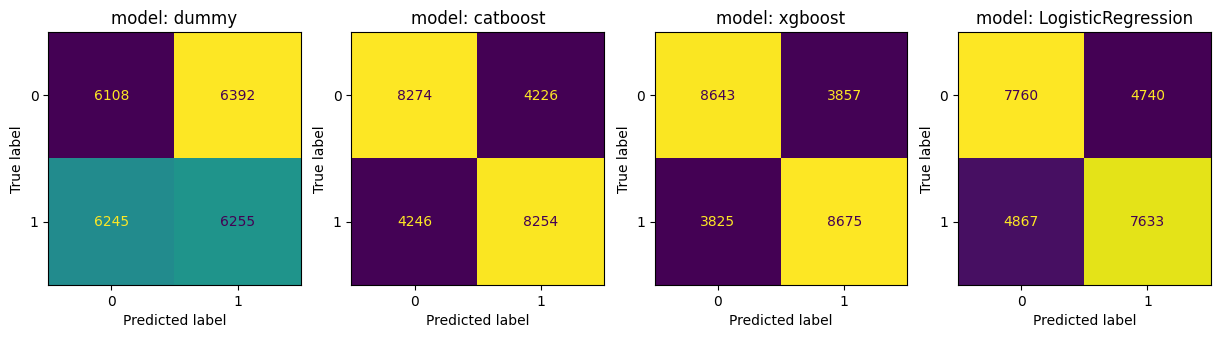

In [30]:
run_models2(XV.toarray(), y1)

In [31]:
# Let's take xgboost once again 
xgboost_clf_v = xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=0)
xgboost_clf_v.fit(XV.toarray(),y1)
y_pred_v = xgboost_clf_v.predict(XV.toarray())
accuracy_score(y1, y_pred_v)

0.69272

In [32]:
def predictv(text):
    #del dft
    return xgboost_clf_v.predict(vectorizer.transform([text]).toarray())[0]

In [33]:
cat[predictv(df_test.iloc[0]['texts'])]

'positive'

### <span style="color:yellow">Now: A weighted tokenization with TfidfVectorizer (Scikit-learn)</span>

In [34]:
vectorizer = TfidfVectorizer(binary=True, max_features=max_features)
XT = vectorizer.fit_transform(df['texts'])

model=dummy, accuracy=0.49484
model=catboost, accuracy=0.66336
model=xgboost, accuracy=0.7168
model=LogisticRegression, accuracy=0.61468


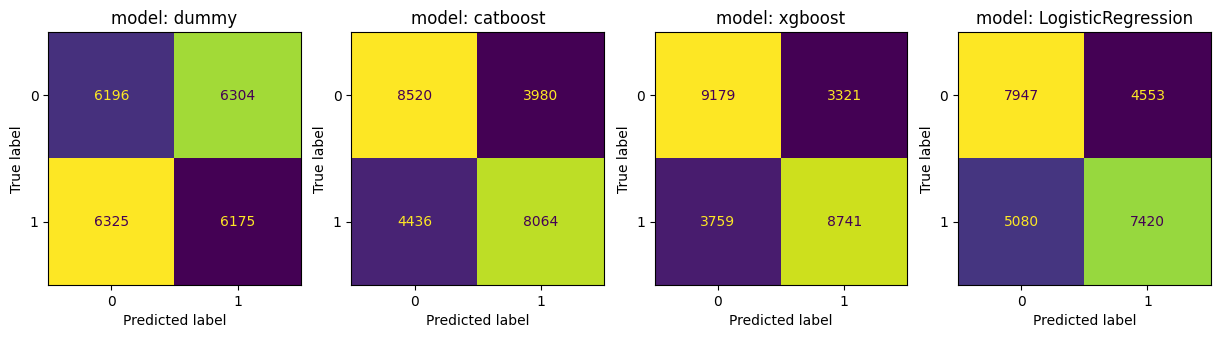

In [35]:
run_models2(XT.toarray(), y1)

In [36]:
# Who is the winner?
xgboost_clf_tfidf = xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=0)
xgboost_clf_tfidf.fit(XT.toarray(),y1)
y_pred_tfidf = xgboost_clf_tfidf.predict(XT.toarray())
accuracy_score(y1, y_pred_tfidf)

0.7168

In [37]:
def predicttfidf(text):
    return xgboost_clf_tfidf.predict(vectorizer.transform([text]).toarray())[0]

In [38]:
cat[predicttfidf(df_test.iloc[0]['texts'])]

'positive'

# Our own take

In [4]:
import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alejo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alejo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# FULL DATABASE

df1 = pd.read_csv('df.csv')
df2 = pd.read_csv('df_test.csv')

# combine the dataframes into one
df = pd.concat([df1, df2], ignore_index=True)
df = df.sample(frac = 1.0, random_state=33)
del df1, df2

In [40]:
# ONLY TRAINING DATABASE

# df = pd.read_csv('df.csv')
# df = df.sample(frac = 1.0, random_state=33)

### Improvement in the pre-processing of the text

In [5]:
lines = df["texts"].values.tolist()

# Define a function to purify the lines of text
def purify(lines):
    all_reviews = list()
    for text in lines:
        # Convert the text to lowercase
        text = text.lower()
        
        # Remove URLs from the text
        pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        text = pattern.sub(' ', text)
        
        # Replace '<br />' with a space
        text = text.replace('<br />', ' ')
        
        # Remove punctuation marks from the text
        text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=]", " ", text)
        
        # Tokenize the text into words
        tokens = word_tokenize(text)
        
        # Remove non-alphabetic words
        words = [word for word in tokens if word.isalpha()]
        
        # Remove stop words, excluding the word "not"
        stop_words = set(stopwords.words("english"))
        stop_words.discard("not") ; print(stop_words)
        words = [w for w in words if not w in stop_words]
        
        # Join the words back into a single string
        words = ' '.join(words)
        
        # Append the purified text to the list of all reviews
        all_reviews.append(words)
    
    # Return the list of purified reviews
    return all_reviews

df["texts_norm"] = purify(lines)

In [41]:
# tokenization
tokens_set = set()
df['texts_norm'].str.split(" ").map(tokens_set.update)

len(tokens_set)

71897

In [6]:
# what are the most frequent tokens? -> Counter(tokens_set).most_common()
cntr = Counter()
df["texts_norm"].str.split(" ").map(cntr.update)
cntr.most_common(n=5)

[('movie', 86799),
 ('film', 78503),
 ('not', 62533),
 ('one', 52297),
 ('like', 39257)]

In [7]:
def get_df_topn(text: pd.Series, topn: int, counter_tokens: Counter):

    top_tokens = [x[0] for x in counter_tokens.most_common(n=topn)]

    def check_top_n(sent_tokens):
        return [int(token in sent_tokens) for token in top_tokens]

    df_topn = text.str.split(" ").map(set).map(check_top_n).apply(pd.Series) # .apply: If func returns a Series object the result will be a DataFrame.
    df_topn.columns = top_tokens

    return df_topn

In [44]:
df_top50 = get_df_topn(df["texts_norm"], topn=50, counter_tokens=cntr)

df_top50

,movie,film,not,one,like,good,would,even,time,story,...,show,know,ever,better,man,still,end,say,scene,scenes
17797,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6458,1,0,0,1,1,0,0,1,1,0,...,0,1,1,0,1,0,1,0,0,0
14478,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14825,0,1,1,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
7523,1,1,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,1,1,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
578,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5848,0,0,1,0,1,1,0,0,1,0,...,1,0,0,0,0,0,0,1,1,1
2439,1,1,1,0,0,1,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [8]:
y = df['labels']
y1 = df['labels'].values.tolist()

In [11]:
# We choose a priori 50 as the number of dimensions we will use for classification
# X = get_df_topn( df['texts_norm'], 50, counter_tokens=cntr).values

max_features = 50

X = get_df_topn( df['texts_norm'], max_features, counter_tokens=cntr)
# Replace the special characters in the column names
new_columns = [col.replace('[', '').replace(']', '').replace('<', '') for col in X.columns]

# Rename the columns in the DataFrame
X.rename(columns=dict(zip(X.columns, new_columns)), inplace=True)

# Add the labels to X and save X
X['labels'] = y
X.to_csv('bag_of_words.csv', index=False)

#y = (df['target'] == 'spam').astype(np.int8).values
#y = df['labels'].factorize()[0]

In [47]:
def get_models2(use_dummy):
    
    models = [('dummy', DummyClassifier(strategy='stratified'))] if use_dummy else []
    
    models += [
        ('catboost', ctb.CatBoostClassifier(n_estimators=50, max_depth=5, random_state=0, verbose=0)),
        ('xgboost', xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=0)),
        ('LogisticRegression', LogisticRegression(random_state=0))
    ] 
    return models

In [48]:
def run_models2(X, y, use_dummy=True, scoring='accuracy', plot_result=False, show_confusion_matrix=True):
    result = []
    #cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    
    num_cols = 4
    if show_confusion_matrix:
        fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(15,10))


    for it, (model_name, model) in enumerate(get_models2(use_dummy)):
        clf = model
        clf.fit(X,y)
        y_pred = clf.predict(X)
        score = accuracy_score(y, y_pred)
        print("model={}, accuracy={}".format(model_name, score))

        if show_confusion_matrix:
            ax = axes[it]
            disp = ConfusionMatrixDisplay.from_predictions(y,y_pred,ax=ax,colorbar=None)
            disp.ax_.set_title('model: {}'.format(model_name))

model=dummy, accuracy=0.49964
model=catboost, accuracy=0.7314
model=xgboost, accuracy=0.74976
model=LogisticRegression, accuracy=0.70008


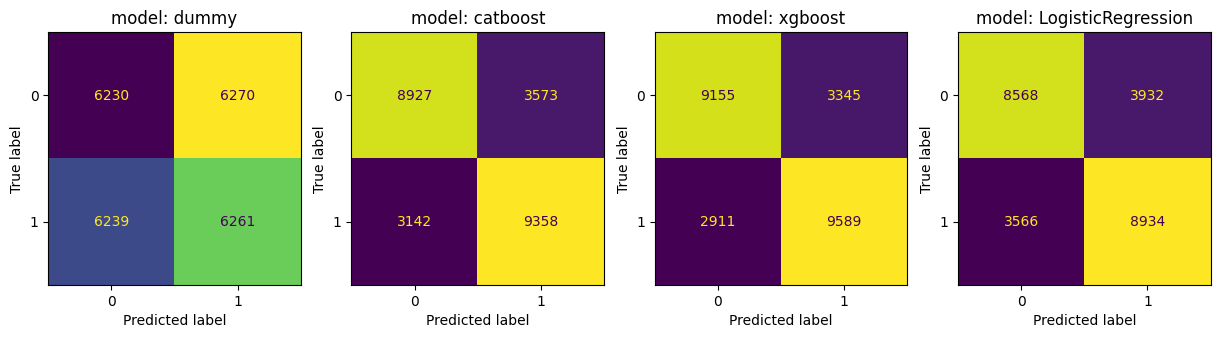

In [49]:
run_models2(X,y1)

### Feature importance of XGBoost

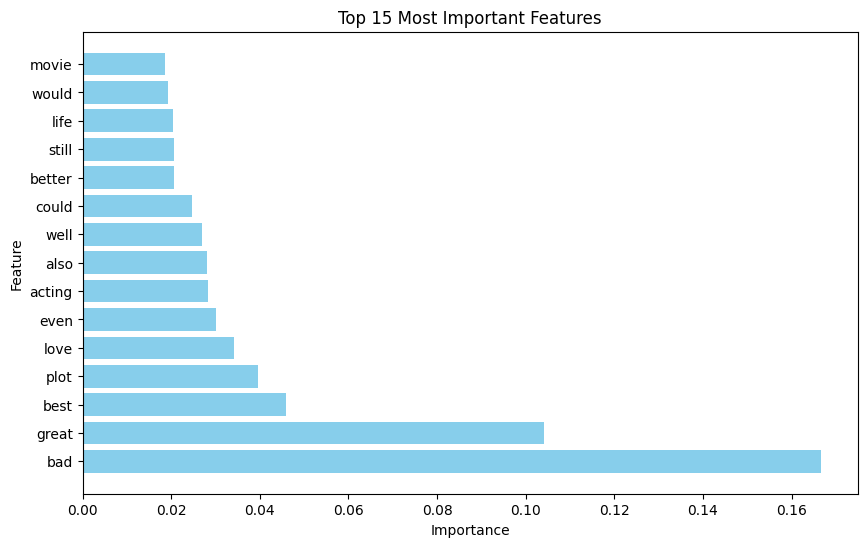

Accuracy: 0.74976
Precision: 0.7413793103448276
Recall: 0.76712
F1-score: 0.7540300385311001


In [67]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize and fit XGBoost classifier
xgboost_clf = xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=0)
xgboost_clf.fit(X, y1)

# Get feature importances
feature_importance = xgboost_clf.feature_importances_

# Create a DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({'Feature': X.columns,
                                      'Importance': feature_importance})

# Sort the DataFrame by importance values
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select top N most important features
top_n_features = 15  # Change this value to adjust the number of features shown
top_n_feature_importance_df = feature_importance_df.head(top_n_features)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_n_feature_importance_df['Feature'], top_n_feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top {} Most Important Features'.format(top_n_features))
plt.show()

# Calculate and display additional metrics
y_pred = xgboost_clf.predict(X)
accuracy = accuracy_score(y1, y_pred)
precision = precision_score(y1, y_pred)
recall = recall_score(y1, y_pred)
f1 = f1_score(y1, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


In [51]:
catboost_clf = ctb.CatBoostClassifier(n_estimators=50, max_depth=5, random_state=0, verbose=0)
catboost_clf.fit(X,y1)

y_pred = catboost_clf.predict(X)
accuracy_score(y1, y_pred)

0.7314

### Feature importance of CATboost

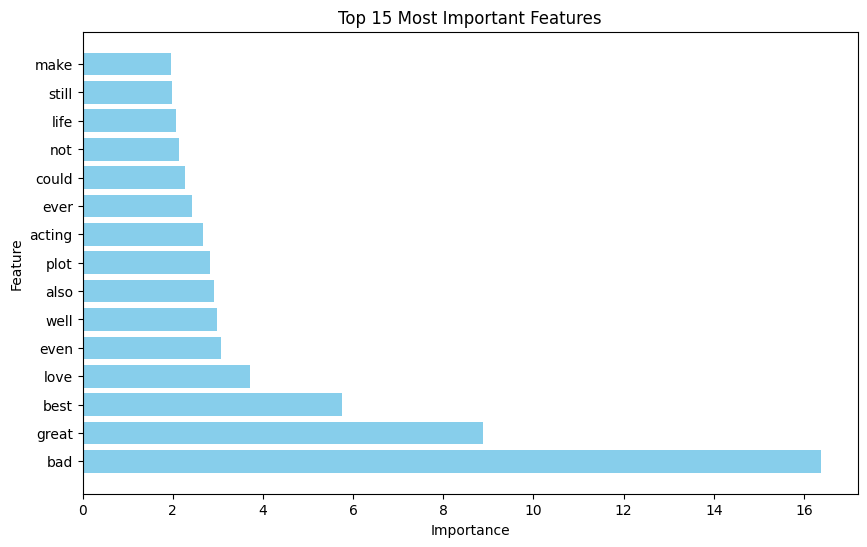

Accuracy: 0.7314
Precision: 0.7236872631660352
Recall: 0.74864
F1-score: 0.7359521843419449


In [52]:
import catboost as ctb
from catboost import Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert DataFrame to Pool object
train_pool = Pool(data=X, label=y1)

# Initialize and fit CatBoost classifier using the Pool object
catboost_clf = ctb.CatBoostClassifier(n_estimators=50, max_depth=5, random_state=0, verbose=0)
catboost_clf.fit(train_pool)

# Get feature importances
feature_importance = catboost_clf.get_feature_importance(data=train_pool,
                                                         type='PredictionValuesChange')

# Create a DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({'Feature': X.columns,
                                      'Importance': feature_importance})

# Sort the DataFrame by importance values
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select top N most important features
top_n_features = 15  # Change this value to adjust the number of features shown
top_n_feature_importance_df = feature_importance_df.head(top_n_features)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_n_feature_importance_df['Feature'], top_n_feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top {} Most Important Features'.format(top_n_features))
plt.show()

# Calculate and display additional metrics
y_pred = catboost_clf.predict(train_pool)
accuracy = accuracy_score(y1, y_pred)
precision = precision_score(y1, y_pred)
recall = recall_score(y1, y_pred)
f1 = f1_score(y1, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


In [53]:
len(y_pred)

25000

In [54]:
def predicta(text):
    # del dft
    # text = purify(text)
    dft = pd.DataFrame({'texts':[text]})
    dft['texts_norm'] = dft['texts'].str.lower()
    return xgboost_clf.predict(get_df_topn(dft["texts_norm"], max_features, counter_tokens=cntr).values)[0]
    # return dft

In [55]:
cat=["negative", "positive"]

In [56]:
cat[predicta(df.iloc[0]['texts_norm'])]

'positive'